In [39]:
import pandas as pd
import numpy as np
import torch

import torch.nn as nn
import torch.optim as optim

In [40]:
doses_cols = ["Delivery", "Raw Material", "Actual Quantity", "Produced Quantity"]
tests_cols = ["Følgeseddel", "Målt konsistens [mm]", "Målt densitet [kg/m3]", "Målt luftinnhold [%]", "Sylinder 28 døgn"]

doses_df = (pd.read_excel("./data/original/Dosering 2019 2024.xlsx", skiprows=4, usecols='C:Q')
            .iloc[1:][doses_cols])

tests_df = (pd.read_excel("./data/original/Fossegrenda_2019_2024_red.xlsx", skiprows=3, usecols='B:AQ')
            .iloc[3:][tests_cols].dropna())

In [41]:
features = doses_df.copy()
features["Actual Quantity"] = doses_df["Actual Quantity"]/doses_df["Produced Quantity"]

features = (features.drop(columns=["Produced Quantity"])
            .pivot_table(index="Delivery", columns="Raw Material", values="Actual Quantity", fill_value=0))
features


Raw Material,U0-22 GJENVUNN 332,U0-4 BREDING,U0-4 VASSFJELL,U0-8 BJØRSET,U0-8 FORSET,U0-8 FORSET 2,U16-22 FORSET,U16-22 MERAFSTAD,U8-16 FORSET,U8-16 MEREFSTAD,...,USA,USCHWENK CEM 111/B,USILIKA 0,USILIKA 1,USILIKA 2,USILIKA ELKEM,USTD-FA KJØPSVIK,UTESTSAND 0-8,UV-VANN,UX-SEED
Delivery,,,,,,,,,,,,,,,,,,,,,
7.0,0.0,0.0,0.000000,0.0,1171.337916,0.000000,0.000000,0.000000,0.000000,714.569011,...,0.0,0.0,0.0,0.000000,0.000000,17.715494,280.142782,0.0,57.112639,3.974088
22.0,0.0,0.0,0.000000,0.0,974.838870,0.000000,0.000000,592.464056,0.000000,348.289539,...,0.0,0.0,0.0,23.425880,0.000000,0.000000,365.642043,0.0,28.631631,0.000000
2015470.0,0.0,0.0,0.000000,0.0,1007.077141,0.000000,0.000000,608.634112,0.000000,288.747346,...,0.0,0.0,0.0,16.135881,0.000000,0.000000,378.910120,0.0,17.353149,0.000000
2015496.0,0.0,0.0,104.277365,0.0,955.100956,0.000000,0.000000,572.529224,0.000000,315.488842,...,0.0,0.0,0.0,16.737513,0.000000,0.000000,276.567481,0.0,47.755048,0.000000
2015503.0,0.0,0.0,143.237841,0.0,1114.590273,0.000000,0.000000,0.000000,0.000000,660.892738,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,360.826116,0.0,105.129913,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2049046.0,0.0,0.0,0.000000,0.0,896.459586,218.436874,0.000000,0.000000,646.626587,0.000000,...,0.0,0.0,0.0,0.000000,24.582498,0.000000,383.700735,0.0,19.812959,0.000000
2049061.0,0.0,0.0,0.000000,0.0,556.213894,478.447637,523.626129,0.000000,287.364835,0.000000,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,368.537994,0.0,12.931418,4.041623
2049073.0,0.0,0.0,0.000000,0.0,584.732386,513.703544,0.000000,0.000000,582.579997,0.000000,...,0.0,0.0,0.0,0.000000,17.362606,0.000000,421.150811,0.0,19.988521,0.000000


In [42]:
targets = tests_df.copy().set_index("Følgeseddel").astype('float')
targets

,Målt konsistens [mm],Målt densitet [kg/m3],Målt luftinnhold [%],Sylinder 28 døgn
Følgeseddel,,,,
1985653,240.0,2486.0,1.8,37.3
1985659,240.0,2242.0,5.8,47.9
1985676,220.0,2303.0,7.0,54.6
1985680,230.0,2414.0,3.6,51.9
1985697,220.0,2357.0,5.8,49.2
...,...,...,...,...
2049025,230.0,2399.0,2.8,56.5
2049038,140.0,2406.0,2.5,63.5
2049061,240.0,2456.0,1.6,46.5


In [105]:
all = targets.join(features, how="inner")

all.dtypes.unique()

y_cols = ["Målt konsistens [mm]", "Målt densitet [kg/m3]", "Målt luftinnhold [%]", "Sylinder 28 døgn"]
all.loc[:, y_cols] = np.log(all[y_cols])

In [106]:

means = all.mean()
stds = all.std()

epsilon = 1e-8
normalized = (all - all.mean()) / (all.std() + epsilon)

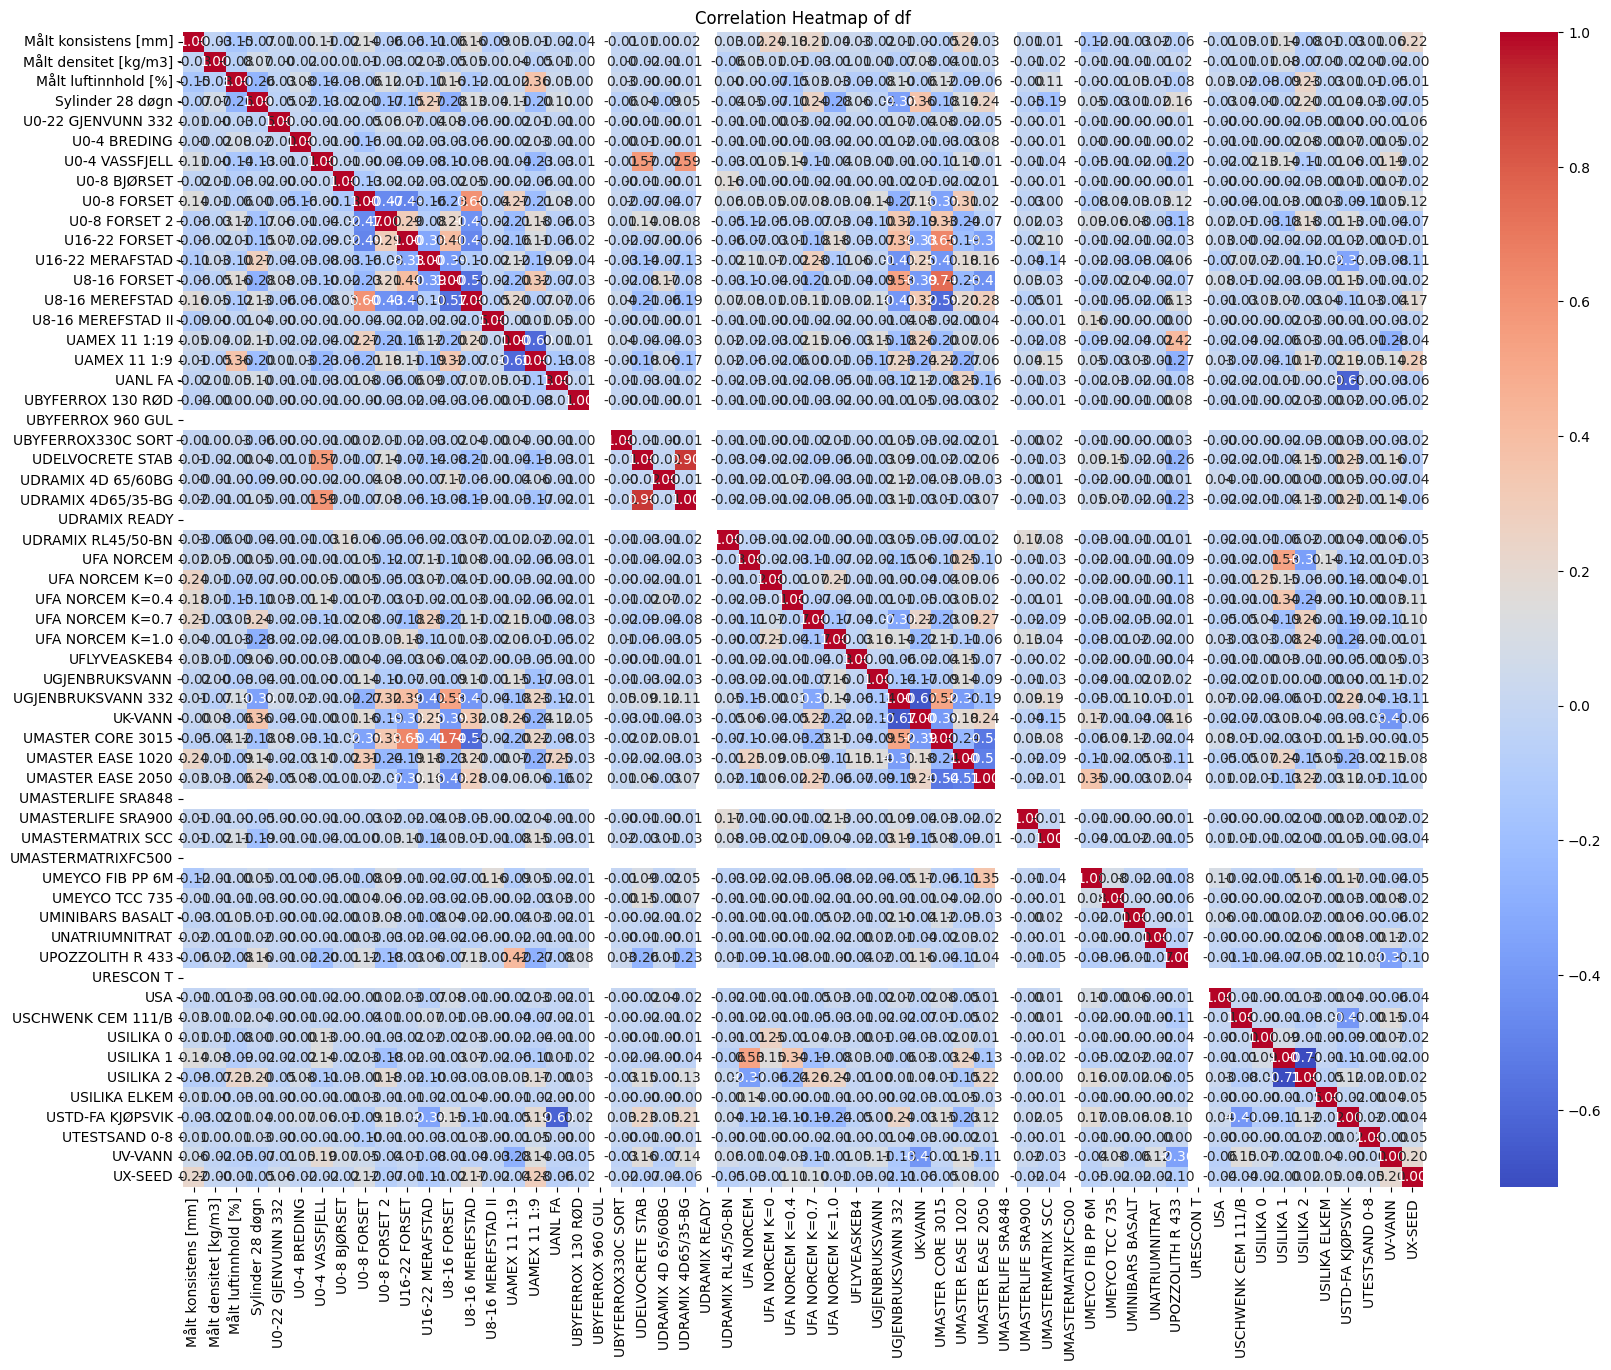

In [107]:
import seaborn as sns

import matplotlib.pyplot as plt

# Compute the correlation matrix
corr = all.corr()

# Generate a heatmap
plt.figure(figsize=(20, 15))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Heatmap of df')
plt.show()

In [108]:
from sklearn.model_selection import train_test_split

# Split the data into 80% train and 20% test
# train_df, test_df = train_test_split(normalized, test_size=0.3, random_state=42)

# # Save the new dataframes to the ./data directory, including the index
# train_df.to_csv('./data/train_df.csv', index=True)
# test_df.to_csv('./data/test_df.csv', index=True)

# means.to_csv('./data/means.csv')
# stds.to_csv('./data/stds.csv')

# Import the train and test dataframes, setting the index column
train_df = pd.read_csv('./data/train_df.csv', index_col=0)
test_df = pd.read_csv('./data/test_df.csv', index_col=0)
means = pd.read_csv('./data/means.csv', index_col = 0)
stds = pd.read_csv('./data/stds.csv', index_col = 0)



train_df

,Målt konsistens [mm],Målt densitet [kg/m3],Målt luftinnhold [%],Sylinder 28 døgn,U0-22 GJENVUNN 332,U0-4 BREDING,U0-4 VASSFJELL,U0-8 BJØRSET,U0-8 FORSET,U0-8 FORSET 2,...,USA,USCHWENK CEM 111/B,USILIKA 0,USILIKA 1,USILIKA 2,USILIKA ELKEM,USTD-FA KJØPSVIK,UTESTSAND 0-8,UV-VANN,UX-SEED
Følgeseddel,,,,,,,,,,,,,,,,,,,,,
2043389,-1.963803,0.180329,-1.649730,0.722952,-0.047716,-0.053041,-0.217093,-0.038939,-1.617477,-0.530188,...,-0.102629,-0.098646,-0.047128,1.941476,-1.774359,-0.027535,0.560428,-0.031466,-0.845848,-0.404574
2039189,-0.260729,-0.073440,0.557323,0.042466,-0.047716,-0.053041,-0.217093,-0.038939,-1.140736,1.183262,...,-0.102629,-0.098646,-0.047128,-0.402451,0.633809,-0.027535,0.644037,-0.031466,-0.746142,-0.404574
2020399,0.062333,-0.033060,1.152388,0.503563,-0.047716,-0.053041,-0.217093,-0.038939,0.433187,-0.530188,...,-0.102629,-0.098646,-0.047128,-0.402451,0.035075,-0.027535,-4.112352,-0.031466,-0.845848,-0.404574
2029699,-0.095526,0.139602,-1.649730,0.378569,-0.047716,-0.053041,-0.217093,-0.038939,-1.197897,1.576407,...,-0.102629,-0.098646,-0.047128,-0.402451,-0.002166,-0.027535,0.251652,-0.031466,1.316059,3.055196
2022170,0.358440,-0.137871,0.164341,-0.297079,-0.047716,-0.053041,-0.217093,-0.038939,0.910351,-0.530188,...,-0.102629,-0.098646,-0.047128,-0.402451,-0.353845,-0.027535,0.574036,-0.031466,-0.845848,-0.404574
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2041419,0.213472,-0.144360,0.039348,0.416307,-0.047716,-0.053041,-0.217093,-0.038939,-1.159576,1.182133,...,-0.102629,-0.098646,-0.047128,-0.402451,0.325795,-0.027535,1.068745,-0.031466,1.345618,-0.404574
2042633,-0.095526,-0.140033,0.940357,-0.024107,-0.047716,-0.053041,-0.217093,-0.038939,1.190006,-0.530188,...,-0.102629,-0.098646,-0.047128,-0.402451,0.558989,-0.027535,-0.273105,-0.031466,0.320851,-0.404574
2048267,-1.226428,-0.280394,1.152388,0.327924,-0.047716,-0.053041,-0.217093,-0.038939,-0.082835,3.592262,...,-0.102629,-0.098646,-0.047128,-0.402451,1.012002,-0.027535,1.382646,-0.031466,1.020790,-0.404574


In [109]:


y = train_df[y_cols]
X = train_df.drop(columns=y_cols)


In [123]:
stds_tensor = torch.tensor(stds.loc[y_cols].to_numpy(), dtype=torch.float32).view(-1, 1)
means_tensor = torch.tensor(means.loc[y_cols].to_numpy(), dtype=torch.float32).view(-1, 1)
# stds_tensor = stds.loc[y_cols].to_numpy()
# means_tensor = means.loc[y_cols].to_numpy()

def denormalizeOutputs(outputs):

    outputs = outputs.view(-1, 1)

    # print("outputs shape:", outputs.shape)
    # print("stds_tensor shape:", stds_tensor.shape)
    # print("means_tensor shape:", means_tensor.shape)

    return torch.exp(outputs * stds_tensor + means_tensor)

In [114]:


# Define the neural network
class SimpleNN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 16)
        self.fc3 = nn.Linear(16, output_dim)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Define the custom loss function
def custom_loss(output, target):
    weights = torch.tensor([0.1, 0.1, 0.1, 0.7], dtype=torch.float32)
    loss = torch.mean(weights * (output - target) ** 2)  # Weighted Mean Squared Error
    return loss

# Convert the data to PyTorch tensors
X_tensor = torch.tensor(X.values, dtype=torch.float32)
y_tensor = torch.tensor(y.values, dtype=torch.float32)

# Convert the test data to PyTorch tensors
X_test_tensor = torch.tensor(test_df.drop(columns=y_cols).values, dtype=torch.float32)
y_test_tensor = torch.tensor(test_df[y_cols].values, dtype=torch.float32)

# Initialize the model, optimizer, and loss function
input_dim = X_tensor.shape[1]
output_dim = y_tensor.shape[1]
model = SimpleNN(input_dim, output_dim)




In [126]:
import matplotlib.pyplot as plt

optimizer = optim.Adam(model.parameters(), lr=0.000005)

# Training loop
num_epochs = 10000
train_losses = []
test_losses = []

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_tensor)
    loss = custom_loss(outputs, y_tensor)
    loss.backward()
    optimizer.step()
    
    train_losses.append(loss.item())
    
    if (epoch) % 100 == 0:
        model.eval()
        with torch.no_grad():
            test_outputs = model(X_test_tensor)
            test_loss = custom_loss(test_outputs, y_test_tensor)
            test_losses.append(test_loss.item())
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Test Loss: {test_loss.item():.4f}')

# Plot the training and test loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(range(99, num_epochs, 100), test_losses, label='Test Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss Over Epochs')
plt.legend()
plt.show()

Epoch [1/10000], Loss: 0.1188, Test Loss: 0.1089
Epoch [101/10000], Loss: 0.1184, Test Loss: 0.1085
Epoch [201/10000], Loss: 0.1179, Test Loss: 0.1081
Epoch [301/10000], Loss: 0.1174, Test Loss: 0.1077
Epoch [401/10000], Loss: 0.1170, Test Loss: 0.1074
Epoch [501/10000], Loss: 0.1165, Test Loss: 0.1070
Epoch [601/10000], Loss: 0.1161, Test Loss: 0.1067
Epoch [701/10000], Loss: 0.1157, Test Loss: 0.1063
Epoch [801/10000], Loss: 0.1152, Test Loss: 0.1060
Epoch [901/10000], Loss: 0.1148, Test Loss: 0.1057
Epoch [1001/10000], Loss: 0.1144, Test Loss: 0.1054
Epoch [1101/10000], Loss: 0.1140, Test Loss: 0.1051
Epoch [1201/10000], Loss: 0.1136, Test Loss: 0.1048
Epoch [1301/10000], Loss: 0.1132, Test Loss: 0.1045
Epoch [1401/10000], Loss: 0.1128, Test Loss: 0.1042
Epoch [1501/10000], Loss: 0.1124, Test Loss: 0.1039
Epoch [1601/10000], Loss: 0.1120, Test Loss: 0.1037
Epoch [1701/10000], Loss: 0.1116, Test Loss: 0.1034
Epoch [1801/10000], Loss: 0.1113, Test Loss: 0.1031
Epoch [1901/10000], Loss

KeyboardInterrupt: 

In [127]:
# Set the model to evaluation mode
model.eval()

# Perform inference on the test data
with torch.no_grad():
    test_outputs = model(X_test_tensor)

# Compute the test loss
test_loss = custom_loss(test_outputs, y_test_tensor)
print(f'Test Loss: {test_loss.item():.4f}')

Test Loss: 0.0948


In [128]:
# Select a few samples from the test dataset for inference
sample_inputs = test_df.drop(columns=y_cols).iloc[:5]

# Convert the sample inputs to PyTorch tensors
sample_inputs_tensor = torch.tensor(sample_inputs.values, dtype=torch.float32)

# Set the model to evaluation mode
model.eval()

# Perform inference
with torch.no_grad():
    sample_outputs = model(sample_inputs_tensor)  # Keep this as a tensor

# Select actual outputs for the same samples (convert to tensor)
actual_outputs_tensor = torch.tensor(test_df[y_cols].iloc[:5].values, dtype=torch.float32)

# Print predictions
for i, (input_row, predicted_output, actual_output) in enumerate(zip(sample_inputs.values, sample_outputs, actual_outputs_tensor)):
    print(f"Sample {i+1}:")
    print(f"Input: {input_row}")
    print(f"Predicted Output: {denormalizeOutputs(predicted_output)}")  # No need for tensor conversion
    print(f"Actual Output: {denormalizeOutputs(actual_output)}")  # No need for conversion
    print()


Sample 1:
Input: [-0.04771631 -0.05304129  4.41189125 -0.03893924 -0.47819987 -0.53018821
 -0.40561922 -0.80828469 -0.48289493 -1.17299452 -0.0453796  -0.40471011
 -1.0554523  -0.15361521 -0.05513174  0.         -0.03895428  5.41264783
 -0.08696855  5.03078483  0.         -0.14686917 -0.2178087  -0.08621575
 -0.13247715 -0.49305999 -0.33603551 -0.08149103 -0.17942945 -0.16380748
 -0.7404869  -0.50482536 -0.47969811  1.01119698  0.         -0.04683895
 -0.18539482  0.         -0.23404733 -0.03895444 -0.09933317 -0.04772736
 -1.46819252  0.         -0.10262942 -0.09864583 -0.04712773  2.84067843
 -1.77435931 -0.02753453  1.31120755 -0.03146611  3.10215368 -0.40457429]
Predicted Output: tensor([[ 254.5931],
        [2369.4246],
        [   3.4202],
        [  46.3259]])
Actual Output: tensor([[ 235.0000],
        [2375.0000],
        [   3.2000],
        [  55.2000]])

Sample 2:
Input: [-0.04771631 -0.05304129 -0.21709289 -0.03893924  0.96440558 -0.53018821
 -0.40561922 -0.80828469  3.266

In [69]:

# Save the model
torch.save(model.state_dict(), './models/simple_nn_model.pth')